## Presentation

In [192]:
import sys
sys.path.append('../src')
import torch
from torchvision import transforms
from torchvision.utils import save_image

# custom libraries
from classes.autoencoder.autoencoderCNN import AutoEncoderCNN
from classes.gan.gan import Generator
from classes.imageclassification.classification import MNIST_Classification_Class

from utils.dataset import load_datasets
from utils.presentationPlot import presentation_plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [193]:
datasettype = "MNIST"

batch_size = 1
z_dim = 100

#### Get Data

In [194]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5], [0.5]
        )
    ]
)

dataset_train, loader_train = load_datasets(datasettype,transform, batch_size=batch_size)

#### Load models

In [195]:
AutoEncoder = AutoEncoderCNN(datasettype=datasettype).to(device)
AutoEncoder = torch.load('autoencoder.pth', map_location=device)
Encoder = AutoEncoder.encoder
Decoder = AutoEncoder.decoder

Gen = Generator(100, z_dim, 28 * 28)
Gen.load_state_dict(torch.load("generator.pth", map_location=device))

Classificator = MNIST_Classification_Class(input_size= 8 * 4 * 4, hidden_dim=100).to(device)
Classificator = torch.load('classificator.pth', map_location=device)

#### Examples

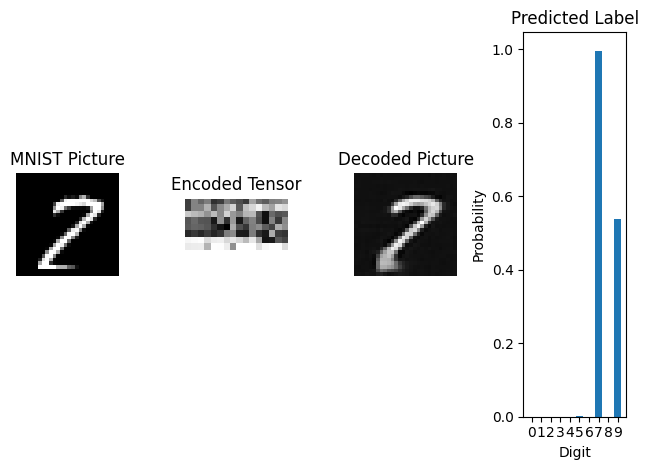

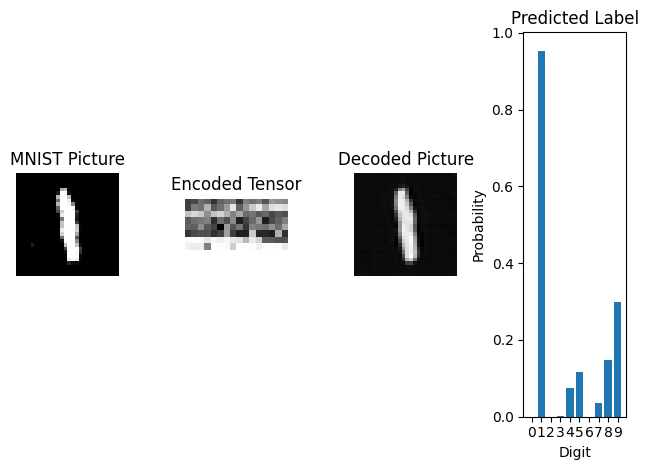

In [196]:
data_iter = iter(loader_train)
for epoch in range(1, 2):
    # real data
    batch = next(data_iter)
    input, label = batch
    real_encoded = Encoder(input)
    real_decoded = Decoder(real_encoded)

    # fake picture
    z = torch.randn(batch_size, z_dim).to(device)
    fake_image = Gen(z)
    fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
    fake_encoded = Encoder(fake_image)
    fake_decoded = Decoder(fake_encoded)
    
    # classify image (based on decoded data)
    classification = Classificator(fake_encoded.view(fake_encoded.size(0), -1))
    real_classification = Classificator(real_encoded.view(real_encoded.size(0), -1))
    # print(classification)

    presentation_plot("MINST Picture",input, real_encoded.view(real_encoded.size(0), 1, 8, 16), real_decoded.view(real_decoded.size(0), 1, 28, 28), real_classification)
    presentation_plot("GAN Generated Picture",fake_image, fake_encoded.view(fake_encoded.size(0), 1, 8, 16), fake_decoded.view(fake_decoded.size(0), 1, 28, 28), classification)
    # save_image(fake_image.view(fake_image.size(0), 1, 28, 28), f'{epoch}_gen.png')
    # save_image(input.view(input.size(0), 1, 28, 28), f'{epoch}.png')
    # save_image(fake_encoded.view(fake_encoded.size(0), 1, 8, 16), f'{epoch}_encoded.png')